In [ ]:
from __future__ import print_function, division
from os.path import dirname, realpath, join
import os
import sys

import numpy as np
import cv2
import yaml

import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
cur = os.getcwd()

In [ ]:
sys.path.append(join(cur, "training"))
sys.path.append(join(cur))

In [ ]:
from train import MultipleVertexJson
from validate import Comparison, Pose, load_model_cm, get_mesh_file, add_metric

In [ ]:
model = "003_cracker_box"
model_cm = load_model_cm(get_mesh_file(model))
def pose_error(X_est, X_gt):
    return add_metric(X_est.R, X_est.t_cm, X_gt.R, X_gt.t_cm, model_cm)

In [ ]:
import cPickle as pickle

In [ ]:
with open("../comp_list.pkl") as f:
    comp_list = pickle.load(f)

In [ ]:
comp_list[0].pose_gt_list[0].t_cm

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
def compute(error_threshold):
    acc = 0.
    for i, comp in enumerate(comp_list):
        acc += comp.compute_accuracy(pose_error, error_threshold)
    return acc / len(comp_list)

In [ ]:
ets = []
accs = []
for error_threshold in tqdm_notebook(np.linspace(0, 100, 100)):
    ets.append(error_threshold / 100)
    accs.append(compute(error_threshold))

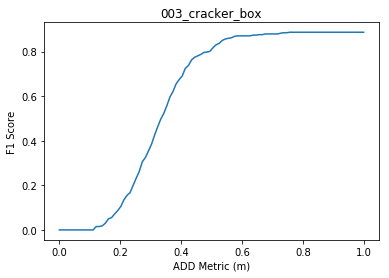

In [50]:
plt.plot(ets, accs)
plt.xlabel("ADD Metric (m)")
plt.ylabel("F1 Score")
plt.title(model)
plt.savefig("/home/eacousineau/proj/tri/proj/perception/plots/simple_stuff.png")